# **Model Setup**

**Required Imports:**

In [ ]:
!huggingface-cli login # login to huggingface with access token gotten from the website

In [1]:
#imports
!pip install datasets # install datasets to download training data
from matplotlib import pyplot as plt
import numpy as np
from datasets import load_dataset
from PIL import Image

tiny_imagenet = load_dataset("zh-plus/tiny-imagenet", split='train') # load training data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

**Optional: Visualize Dataset:**

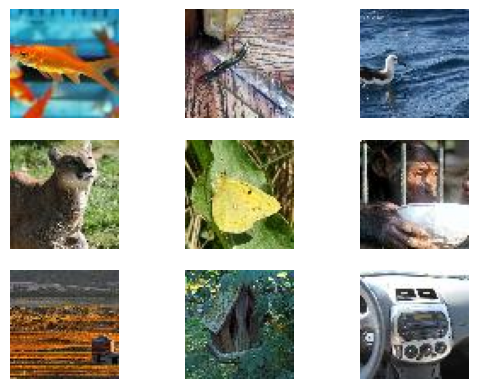

In [ ]:
offset = 50
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	plt.axis('off') # remove axis indicators

	# plot raw pixel data
	plt.imshow(tiny_imagenet[i+offset]["image"])
	offset += 5000
# show the figure
plt.show()

**Setup RGB <--> LAB Conversion:**

In [2]:
import numpy as np
def gammaToLinear(c):
  if (c >= 0.04045):
    return ((c + 0.055) / 1.055) ** 2.4
  else:
    return c / 12.92

def linearToGamma(c):
  if (c >= 0.0031308):
    return 1.055 * c ** (1 / 2.4) - 0.055
  else:
    return 12.92 * c

def clampRGB(n):
  return max(0, min(n, 255))

def rgbToOklab(r, g, b):
  # convert from 255 scale to percentage scale
  r = gammaToLinear(r/255.0)
  g = gammaToLinear(g/255.0)
  b = gammaToLinear(b/255.0)

  #convert to LAB:
  l = 0.4122214708 * r + 0.5363325363 * g + 0.0514459929 * b
  m = 0.2119034982 * r + 0.6806995451 * g + 0.1073969566 * b
  s = 0.0883024619 * r + 0.2817188376 * g + 0.6299787005 * b

  l = np.cbrt(l)
  m = np.cbrt(m)
  s = np.cbrt(s)

  return [l * 0.2104542553 + m * 0.7936177850 + s * -0.0040720468,
          l * 1.9779984951 + m * -2.4285922050 + s * 0.4505937099,
          l * 0.0259040371 + m * 0.7827717662 + s * -0.8086757660]


def okLabToRgb(L, a, b):
  l = L + a * +0.3963377774 + b * +0.2158037573
  m = L + a * -0.1055613458 + b * -0.0638541728
  s = L + a * -0.0894841775 + b * -1.2914855480

  l = l ** 3
  m = m ** 3
  s = s ** 3

  r = l * 4.0767416621 + m * -3.3077115913 + s * 0.2309699292;
  g = l * -1.2684380046 + m * 2.6097574011 + s * -0.3413193965;
  b = l * -0.0041960863 + m * -0.7034186147 + s * 1.7076147010;

  r = 255 * linearToGamma(r)
  g = 255 * linearToGamma(g)
  b = 255 * linearToGamma(b)

  r = clampRGB(r)
  g = clampRGB(g)
  b = clampRGB(b)

  return [r, g, b]

# Test conversion:
lab = rgbToOklab(100, 50, 50)
print(okLabToRgb(lab[0], lab[1], lab[2]))

[100.00000089302695, 49.999999043071405, 49.999990378947395]


# **Prepare Dataset: Convert or Load**

**Option 1: Convert dataset to LAB:**

In [ ]:
lab_images = np.empty((40000, 64, 64, 3))
count = 0

for feat_count in range(40000):
  image_mode = tiny_imagenet[feat_count]["image"].mode

  if (image_mode != "RGB"):
    continue

  rgb_data = np.array(tiny_imagenet[feat_count]["image"])
  lab_data = np.empty((64, 64, 3)) #store lab data from image

  for i in range(64):
    for j in range(64):
      lab = rgbToOklab(rgb_data[i][j][0], rgb_data[i][j][1], rgb_data[i][j][2])
      lab_data[i][j] = lab

  count += 1
  lab_images[feat_count] = lab_data

np.save('/content/drive/MyDrive/labdata.npy', lab_images)


**Optional: Test conversion between LAB and RGB images**

<ipython-input-21-4f050463cfa1>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(332)


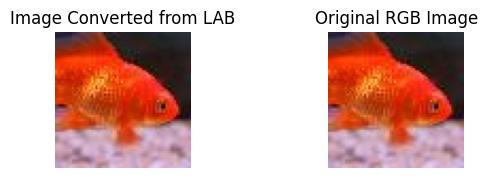

In [ ]:
test_image_num = 100 # determines which image to test the conversion on

img_data = np.empty((64, 64, 3)) # store RGB image data

# convert image back to RGB to display:
for i in range(64):
  for j in range(64):
    img_data[i][j] = okLabToRgb(lab_images[test_image_num][i][j][0], lab_images[test_image_num][i][j][1], lab_images[test_image_num][i][j][2])

img_data = img_data.astype(np.uint8) # convert from float to integer
img = Image.fromarray(img_data) # create image from data

plt.subplots(figsize=(10, 6))

plt.subplot(332)
plt.imshow(img) #display image
plt.title("Image Converted from LAB")
plt.axis("off")

plt.subplot(333)
plt.imshow(tiny_imagenet[test_image_num]["image"]) # original image
plt.title("Original RGB Image")
plt.axis("off")

plt.show()

**Option 2: Load Existing LAB Data:**

In [3]:
from google.colab import drive
drive.mount('/content/drive')
load_path = '/content/drive/MyDrive/labdata.npy' #lab data path in drive

lab_images = np.load(load_path)
print(lab_images.shape) #ensure loading was a success

Mounted at /content/drive
(40000, 64, 64, 3)


**Split images into categories**

In [ ]:
from sklearn.cluster import KMeans
import pickle

# Reshape the data to 2D
reshaped_images = lab_images.reshape(lab_images.shape[0], -1)

kmeans = KMeans(n_clusters=4, random_state=0).fit(reshaped_images)

categories = kmeans.labels_

print(categories.shape)

# # Save the labels to a file
with open('/content/drive/MyDrive/categories.pkl', 'wb') as f:
     pickle.dump(categories, f)

# arrange images into their sorted categories for visulization/testing:
sorted_lab_images = [[] for _ in range(4)]

for i, category in enumerate(categories):
  sorted_lab_images[category].append(lab_images[i]) # move image into corresponding category

with open("/content/drive/MyDrive/sorted_lab_images.pkl", "wb") as f: # save sorted image data to file for future use
    pickle.dump(sorted_lab_images, f)

print("The images have been successfully sorted into 4 categories based on color similarity and the result has been saved to 'categories.pkl'.")


**Load Categories From File:**

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Load the labels from the file
with open('/content/drive/MyDrive/categories.pkl', 'rb') as f:
    categories = pickle.load(f)

print(categories.shape) # ensure loading was a success

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(40000,)


**Load Sorted Lab Images From File:**

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Load the labels from the file
with open('/content/drive/MyDrive/sorted_lab_images.pkl', 'rb') as f:
    sorted_lab_images = pickle.load(f)

print(len(sorted_lab_images[0])) # ensure loading was a success

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
12904


**Optional: Visualise Image Categories**

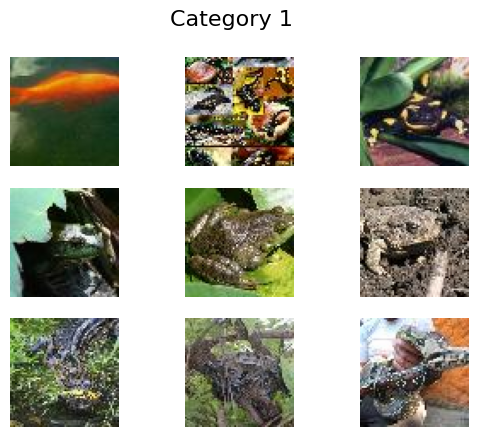

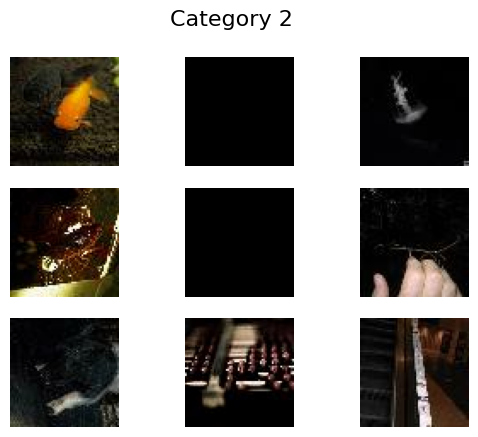

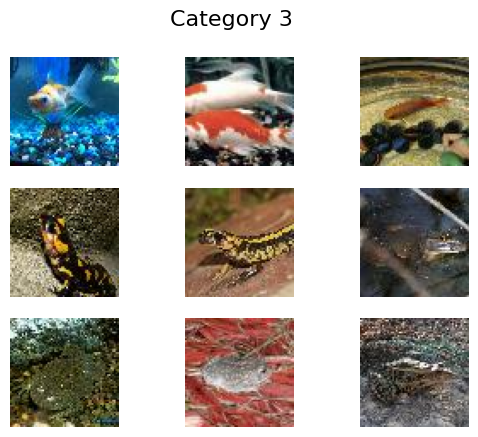

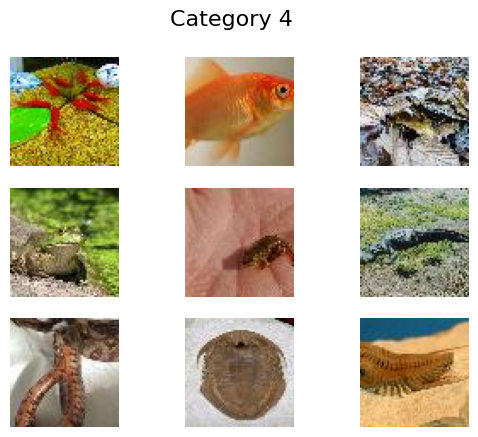

In [ ]:
for category_index in range(4):
  offset = 10
  for c in range(9):
    plt.subplot(330 + 1 + c)
    plt.axis('off')

    img_data = np.empty((64, 64, 3))
    for i in range(64):
      for j in range(64):
        img_data[i][j] = okLabToRgb(sorted_lab_images[category_index][offset][i][j][0], sorted_lab_images[category_index][offset][i][j][1], sorted_lab_images[category_index][offset][i][j][2])

    img_data = img_data.astype(np.uint8) # convert from float to integer
    img = Image.fromarray(img_data) # create image from data

    plt.imshow(img)
    offset += 100

  # show the figure
  plt.suptitle("Category " + (str)(category_index+1), fontsize=16)
  plt.show()

# **Loss Functions:**

**Create Weights for Each Category:**

In [4]:
import tensorflow as tf

# Get Color Weights
#a_channel = np.array(sorted_lab_images[0])[..., 1]
#b_channel = np.array(sorted_lab_images[0])[..., 2]
a_channel = lab_images[..., 1]
b_channel = lab_images[..., 2]

a_hist, a_bins = np.histogram(a_channel, bins=64) # sort into 64 bins based on color rarity
b_hist, b_bins = np.histogram(b_channel, bins=64) # sort into 64 bins based on color rarity

#inverse sqrt to make give rare colors precidence, small value added to prevent divide by 0 errors
a_weights = 1 / np.sqrt(a_hist + 1e-8)
b_weights = 1 / np.sqrt(b_hist + 1e-8)

weights = np.stack([a_weights, b_weights], axis=-1) # combine a and b axis into weights tensor
weights = tf.constant(weights, dtype=tf.float32) # convert to tensor for use in tf operations

# Normalize the weights to ensure they sum to 1
weights = weights / tf.reduce_sum(weights, axis=(0, 1), keepdims=True)

**Setup Loss Functions:**

In [5]:
import tensorflow as tf
from keras.saving import register_keras_serializable

@register_keras_serializable()
def tf_digitize(x, bins):
  bins = tf.cast(bins, tf.float32)  # Convert bins to float32
  bins = tf.expand_dims(bins, axis=0)  # Add an extra dimension at the beginning
  bins = tf.expand_dims(bins, axis=-1)  # Add an extra dimension at the end
  bins = tf.tile(bins, [tf.shape(x)[0], 1, tf.shape(x)[1]])  # Tile bins to match the shape of x
  bin_indices = tf.searchsorted(bins, x, side='right') # match predicted values to their bins
  return bin_indices

@register_keras_serializable()
def custom_color_loss(y_true, y_pred):
  pred_a = y_pred[..., 0]
  pred_b = y_pred[..., 1]
  true_a = y_true[..., 0]
  true_b = y_true[..., 1]

  # apply weights to predictions:

  # Determine the bin indices for each pixel
  a_bin_indices = tf_digitize(pred_a, a_bins[:-1])
  b_bin_indices = tf_digitize(pred_b, b_bins[:-1])

  #get weights for each bin:
  a_weights = tf.gather(weights[..., 0], a_bin_indices)
  b_weights = tf.gather(weights[..., 1], b_bin_indices)

  # apply MSE loss with rare color weights
  custom_loss = a_weights * (true_a - pred_a)**2 + b_weights * (true_b - pred_b)**2

  # calculate standard MSE loss
  mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

  # blend custom loss and MSE loss with blending value 0.35 and 0.65 (can be fine tuned with different blending values)
  return 0.35 * custom_loss + 0.65 * mse_loss

# **Predictor Model**

**Create Predictor Model:**

In [ ]:
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense

inputs = Input(shape=(64, 64, 1))

#convolution block 1
conv1 = Conv2D(32, 3, activation='relu')(inputs)
maxPool1 = MaxPool2D(pool_size=(2, 2))(conv1)

#conv block 2
conv2 = Conv2D(64, 3, activation='relu')(maxPool1)
maxPool2 = MaxPool2D(pool_size=(2, 2))(conv2)

#conv block 3
conv3 = Conv2D(128, 3, activation='relu')(maxPool2)
maxPool3 = MaxPool2D(pool_size=(2, 2))(conv3)

#Flatten and classification:
flatten = Flatten()(maxPool3)
dense1 = Dense(128, activation='relu')(flatten)
classificationDense = Dense(4, activation='softmax')(dense1)

prediction_model = tf.keras.Model(inputs=inputs, outputs=classificationDense)

prediction_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Train Predictor Model:**

In [ ]:
from tensorflow.keras.utils import to_categorical

one_hot_labels = to_categorical(categories) # one hot encoding for labels

train_images = lab_images[:32000, :, :, 0] # 80% train split
val_images = lab_images[32000:, :, :, 0] # 20% validation split

train_labels = one_hot_labels[:32000] # train labels
val_labels = one_hot_labels[32000:] # validation labels

# train model:
pred_history = prediction_model.fit(
    x=train_images,
    y=train_labels,
    epochs=20,
    validation_data=(val_images, val_labels)
)

#save trained model:
prediction_model.save('/content/drive/MyDrive/prediction_model.keras')

**Graph Prediction Results:**

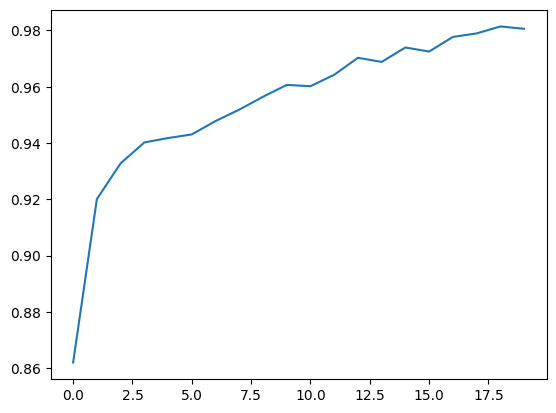

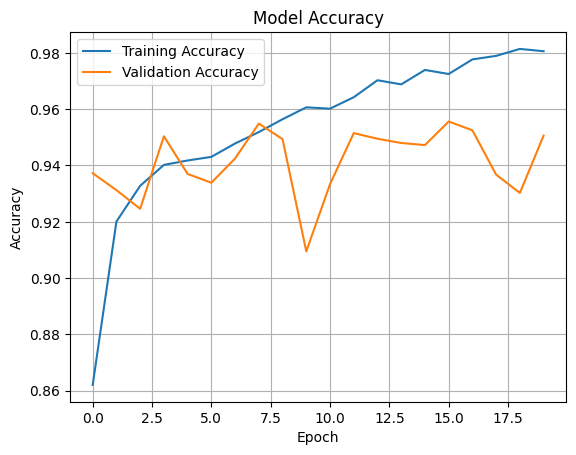

In [ ]:
from matplotlib import pyplot as plt
# Prepare data
epochs = pred_history.epoch
accuracy = pred_history.history['accuracy']
val_accuracy = pred_history.history['val_accuracy']

# Plot the graph
plt.plot(epochs, accuracy, label='Accuracy')

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the training accuracy
ax.plot(epochs, accuracy, label='Training Accuracy')

# Plot the validation accuracy
ax.plot(epochs, val_accuracy, label='Validation Accuracy')

# Add labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy')

# Add legend and grid
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

**Test Predictor:**

In [ ]:
image_num = 1000 # selects image from dataset to run through the model

# test model on one image:
starting_image = lab_images[image_num]
reshaped_image = starting_image[:, :, 0]
reshaped_image = reshaped_image.reshape((1, 64, 64, 1))

prediction = prediction_model.predict(reshaped_image) # predict ab values

print(prediction)
print(one_hot_labels[image_num])

1/1 [==============================] - 0s 28ms/step
[[9.9999726e-01 2.4724977e-11 2.7012129e-06 3.9912256e-09]]
[1. 0. 0. 0.]


# **Create and Train Colorizer Models**

**Create Model:**

In [ ]:
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, Concatenate, Conv2DTranspose, MaxPool2D, Activation, UpSampling2D

# Input layer
inputs = Input(shape=(64, 64, 1))

# Encoder
conv1 = Conv2D(64, 3, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = ReLU()(conv1)
conv1 = Conv2D(64, 3, padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = ReLU()(conv1)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = ReLU()(conv2)
conv2 = Conv2D(128, 3, padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = ReLU()(conv2)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = ReLU()(conv3)
conv3 = Conv2D(256, 3, padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = ReLU()(conv3)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, padding='same')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = ReLU()(conv4)
conv4 = Conv2D(512, 3, padding='same')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = ReLU()(conv4)

# Decoder
up1 = UpSampling2D(size=(2, 2))(conv4)
concat1 = Concatenate()([up1, conv3])
conv5 = Conv2D(256, 3, padding='same')(concat1)
conv5 = BatchNormalization()(conv5)
conv5 = ReLU()(conv5)
conv5 = Conv2D(256, 3, padding='same')(conv5)
conv5 = BatchNormalization()(conv5)
conv5 = ReLU()(conv5)

up2 = UpSampling2D(size=(2, 2))(conv5)
concat2 = Concatenate()([up2, conv2])
conv6 = Conv2D(128, 3, padding='same')(concat2)
conv6 = BatchNormalization()(conv6)
conv6 = ReLU()(conv6)
conv6 = Conv2D(128, 3, padding='same')(conv6)
conv6 = BatchNormalization()(conv6)
conv6 = ReLU()(conv6)

up3 = UpSampling2D(size=(2, 2))(conv6)
concat3 = Concatenate()([up3, conv1])
conv7 = Conv2D(64, 3, padding='same')(concat3)
conv7 = BatchNormalization()(conv7)
conv7 = ReLU()(conv7)
conv7 = Conv2D(64, 3, padding='same')(conv7)
conv7 = BatchNormalization()(conv7)
conv7 = ReLU()(conv7)

# Output for a and b channels
output_ab = Conv2D(2, 1, activation='tanh')(conv7)

model = tf.keras.Model(inputs=inputs, outputs=output_ab)

# Compile the model
model.compile(loss=custom_color_loss, optimizer='adam', metrics=['accuracy'])
#model.summary()

**Prepare data splits and train model:**

In [ ]:
lab_labels = lab_images[:, :, :, 1:3] # extract the last two color channels to be labels

train_images = lab_images[:32000, :, :, 0] # 80% train split
val_images = lab_images[32000:, :, :, 0] # 20% validation split

train_labels = lab_labels[:32000] # train labels
val_labels = lab_labels[32000:] # validation labels

# train model:
history = model.fit(
    x=train_images,
    y=train_labels,
    epochs=20,
    validation_data=(val_images, val_labels)
)

#save trained model:
model.save('/content/drive/MyDrive/test_model.keras')

**Train With Categories:**

In [ ]:
# category = np.array(sorted_lab_images[0]);
# split = round(len(category) * 0.8)

# lab_labels = category[:, :, :, 1:3] # extract the last two color channels to be labels

# train_images = category[:split, :, :, 0] # 80% train split
# val_images = category[split:, :, :, 0] # 20% validation split

# train_labels = lab_labels[:split] # train labels
# val_labels = lab_labels[split:] # validation labels

# # train model:
# history = model.fit(
#     x=train_images,
#     y=train_labels,
#     epochs=20,
#     validation_data=(val_images, val_labels)
# )

# #save trained model:
# model.save('/content/drive/MyDrive/color_rarity_model.keras')

**Optional: Graph Accuracy Metrics**

In [ ]:
from matplotlib import pyplot as plt
# Prepare data
epochs = history.epoch
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the graph
plt.plot(epochs, accuracy, label='Accuracy')

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the training accuracy
ax.plot(epochs, accuracy, label='Training Accuracy')

# Plot the validation accuracy
ax.plot(epochs, val_accuracy, label='Validation Accuracy')

# Add labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy')

# Add legend and grid
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

# **Load Existing Model:**

**Load Prediction Model**

In [ ]:
from keras.models import load_model

# Load the model
prediction_model = load_model('/content/drive/MyDrive/prediction_model.keras')

**Load Colorizer Models:**

In [6]:
from keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/test_model.keras', custom_objects={'custom_color_loss': custom_color_loss})

# Loading a model that uses custom_color_loss requires initializing the function before running this block

# **Use Model:**

**Test Image in Dataset:**

1/1 [==============================] - 0s 21ms/step


<ipython-input-8-2a5daef5a26f>:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(331)


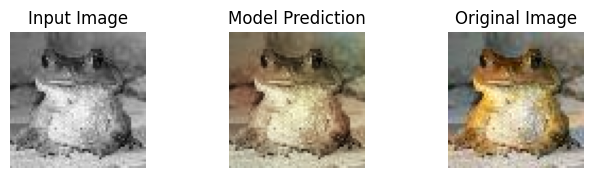

In [8]:
from PIL import Image

image_num = 1442 # selects image from dataset to run through the model

# test model on one image:
starting_image = lab_images[image_num]
reshaped_image = starting_image[:, :, 0]
reshaped_image = reshaped_image.reshape((1, 64, 64, 1))

prediction = model.predict(reshaped_image) # predict ab values

# Extract the predicted a and b channels
predicted_a = prediction[0, :, :, 0]
predicted_b = prediction[0, :, :, 1]

img_data = np.empty((64, 64, 3)) # to store RGB image data

# convert image back to RGB to display:
for i in range(64):
  for j in range(64):
    img_data[i][j] = okLabToRgb(starting_image[i][j][0], predicted_a[i][j], predicted_b[i][j])

img_data = img_data.astype(np.uint8) # convert from float to integer

img = Image.fromarray(img_data) # create image from data

# plot images:
plt.subplots(figsize=(8, 6))

plt.subplot(331)
plt.imshow(tiny_imagenet[image_num]["image"].convert("L"), cmap='gray') #display image
plt.title("Input Image")
plt.axis('off')

plt.subplot(332)
plt.imshow(img) #display image
plt.title("Model Prediction")
plt.axis('off')

plt.subplot(333)
plt.imshow(tiny_imagenet[image_num]["image"]) # original image
plt.title("Original Image")
plt.axis('off')

plt.show()

**Test image from file:**

Saving test_image2.jpg to test_image2.jpg
1/1 [==============================] - 3s 3s/step


<ipython-input-7-3e5ac8e0b7c1>:52: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(331)


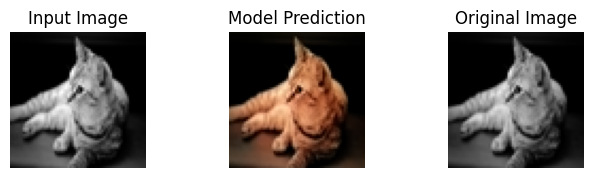

In [7]:
from google.colab import files
from PIL import Image
from io import BytesIO

# Upload files and filter for images only
uploaded = files.upload()
images = {name: content for name, content in uploaded.items() if name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))}

# Assuming there's at least one image
if images:
  # Get the first image filename
  filename = next(iter(images))
  # Open the image file
  image = Image.open(BytesIO(images[filename])) # open file
  image = image.resize((64, 64), Image.BICUBIC) # downscale image to 64 x 64
  lab_image = np.empty((64, 64, 3)) # store lab data

  if (image.mode != "LAB"): # if image is not in Lab Space, convert it
    rgb_data = np.array(image)
    img_data = np.empty((64, 64, 3))

    for i in range(64):
      for j in range(64):
        img_data[i][j] = rgbToOklab(rgb_data[i][j][0], rgb_data[i][j][1], rgb_data[i][j][2])

    lab_image = img_data
  else:
    lab_image = np.array(image) # get lab data from image

  reshaped_image = lab_image[:, :, 0] # extract L channel
  reshaped_image = reshaped_image.reshape((1, 64, 64, 1)) # reshape to required model input

  prediction = model.predict(reshaped_image) # predict ab values

  # Extract the predicted a and b channels
  predicted_a = prediction[0, :, :, 0]
  predicted_b = prediction[0, :, :, 1]

  img_data = np.empty((64, 64, 3)) # to store RGB image data

  # convert image back to RGB to display:
  for i in range(64):
    for j in range(64):
      img_data[i][j] = okLabToRgb(lab_image[i][j][0], predicted_a[i][j], predicted_b[i][j])
  img_data = img_data.astype(np.uint8) # convert from float to integer

  model_result = Image.fromarray(img_data) # create image from data

  # plot result:
  plt.subplots(figsize=(8, 6))

  plt.subplot(331)
  plt.imshow(image.convert("L"), cmap='gray') #display image
  plt.title("Input Image")
  plt.axis('off')

  plt.subplot(332)
  plt.imshow(model_result) #display image
  plt.title("Model Prediction")
  plt.axis('off')

  plt.subplot(333)
  plt.imshow(image) # original image
  plt.title("Original Image")
  plt.axis('off')

  plt.show()
else:
  print('No image files were uploaded.')

**Compare Colorizer with and without loss function:**

In [9]:
from keras.models import load_model

# Load the model
old_model = load_model('/content/drive/MyDrive/66accuracy_model.keras')

# Loading a model that uses custom_color_loss requires initializing the function before running this block

1/1 [==============================] - 0s 33ms/step


<ipython-input-111-ef5820f6ba6e>:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(331)


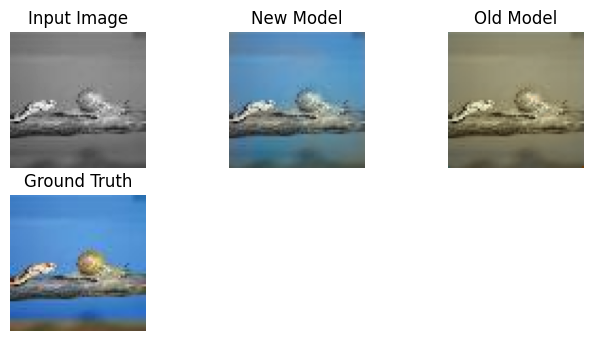

In [111]:
from PIL import Image

image_num = 7000 # selects image from dataset to run through the model

# test model on one image:
starting_image = lab_images[image_num]
reshaped_image = starting_image[:, :, 0]
reshaped_image = reshaped_image.reshape((1, 64, 64, 1))

prediction = model.predict(reshaped_image) # predict ab values
old_prediction = old_model.predict(reshaped_image)

# Extract the predicted a and b channels
predicted_a = prediction[0, :, :, 0]
predicted_b = prediction[0, :, :, 1]

img_data = np.empty((64, 64, 3)) # to store RGB image data

# convert image back to RGB to display:
for i in range(64):
  for j in range(64):
    img_data[i][j] = okLabToRgb(starting_image[i][j][0], predicted_a[i][j], predicted_b[i][j])

img_data = img_data.astype(np.uint8) # convert from float to integer

img = Image.fromarray(img_data) # create image from data

# Extract the predicted a and b channels
old_predicted_a = old_prediction[0, :, :, 0]
old_predicted_b = old_prediction[0, :, :, 1]

old_img_data = np.empty((64, 64, 3)) # to store RGB image data

# convert image back to RGB to display:
for i in range(64):
  for j in range(64):
    old_img_data[i][j] = okLabToRgb(starting_image[i][j][0], old_predicted_a[i][j], old_predicted_b[i][j])

old_img_data = old_img_data.astype(np.uint8) # convert from float to integer

old_img = Image.fromarray(old_img_data) # create image from data

# plot images:
plt.subplots(figsize=(8, 6))

plt.subplot(331)
plt.imshow(tiny_imagenet[image_num]["image"].convert("L"), cmap='gray') #display image
plt.title("Input Image")
plt.axis('off')

plt.subplot(332)
plt.imshow(img) #new model
plt.title("New Model")
plt.axis('off')

plt.subplot(333)
plt.imshow(old_img) # old model
plt.title("Old Model")
plt.axis('off')

plt.subplot(334)
plt.imshow(tiny_imagenet[image_num]["image"]) # original image
plt.title("Ground Truth")
plt.axis('off')

plt.show()

**Test Category Model:**

In [ ]:
# category = np.array(sorted_lab_images[0]); # select which category to test

In [ ]:
# from PIL import Image

# image_num = 6969 # selects image from dataset to run through the model

# # test model on one image:
# starting_image = category[image_num]

# starting_image_rgb = np.empty((64, 64, 3)) # to store RGB image data
# for i in range(64):
#   for j in range(64):
#     starting_image_rgb[i][j] = okLabToRgb(starting_image[i][j][0], starting_image[i][j][1], starting_image[i][j][2])
# starting_image_rgb = starting_image_rgb.astype(np.uint8) # convert from float to integer

# reshaped_image = starting_image[:, :, 0]
# reshaped_image = reshaped_image.reshape((1, 64, 64, 1))

# prediction = model.predict(reshaped_image) # predict ab values

# # Extract the predicted a and b channels
# predicted_a = prediction[0, :, :, 0]
# predicted_b = prediction[0, :, :, 1]

# img_data = np.empty((64, 64, 3)) # to store RGB image data

# # convert image back to RGB to display:
# for i in range(64):
#   for j in range(64):
#     img_data[i][j] = okLabToRgb(starting_image[i][j][0], predicted_a[i][j], predicted_b[i][j])

# img_data = img_data.astype(np.uint8) # convert from float to integer

# img = Image.fromarray(img_data) # create image from data
# real_image = Image.fromarray(starting_image_rgb)

# # plot images:
# plt.subplots(figsize=(8, 6))

# plt.subplot(331)
# plt.imshow(real_image.convert('L'), cmap='gray') #display image
# plt.title("Input Image")
# plt.axis('off')

# plt.subplot(332)
# plt.imshow(img) #display image
# plt.title("Model Prediction")
# plt.axis('off')

# plt.subplot(333)
# plt.imshow(real_image) # original image
# plt.title("Original Image")
# plt.axis('off')

# plt.show()